In [1]:
import numpy as np 
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
# importing the tools to help us perform cross-validation.
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
# import some metrics we can use to evaluate our model performance later.
from sklearn.metrics import mean_squared_error, r2_score
# import a way to persist our model for future use.
from sklearn.externals import joblib
from sklearn.preprocessing import Imputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt      # matplotlib.pyplot plots data
import warnings
import seaborn as sns
from sklearn.metrics import roc_auc_score

## Reading Dataset

In [2]:
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv(r"C:\Users\amandeep.singh\Desktop\data.csv", delimiter=",")
type(data)

pandas.core.frame.DataFrame

## Data Exploration

In [4]:
data.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


In [5]:
data.shape

(981, 13)

## Checking for data sparcity

In [6]:
num_obs = len(data)
num_true = len(data.loc[data['Loan_Status'] == 'Y'])
num_false = len(data.loc[data['Loan_Status'] == 'N'])
print("Number of True cases:  {0} ({1:2.2f}%)".format(num_true, (num_true/num_obs) * 100))
print("Number of False cases: {0} ({1:2.2f}%)".format(num_false, (num_false/num_obs) * 100))

Number of True cases:  722 (73.60%)
Number of False cases: 259 (26.40%)


## Get Correlation between parameters

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
ApplicantIncome,1.000000,-0.114247,0.551811,-0.023089,0.023378
CoapplicantIncome,-0.114247,1.000000,0.179228,-0.043860,-0.027253
LoanAmount,0.551811,0.179228,1.000000,0.055636,-0.008235
Loan_Amount_Term,-0.023089,-0.043860,0.055636,1.000000,-0.020439
Credit_History,0.023378,-0.027253,-0.008235,-0.020439,1.000000


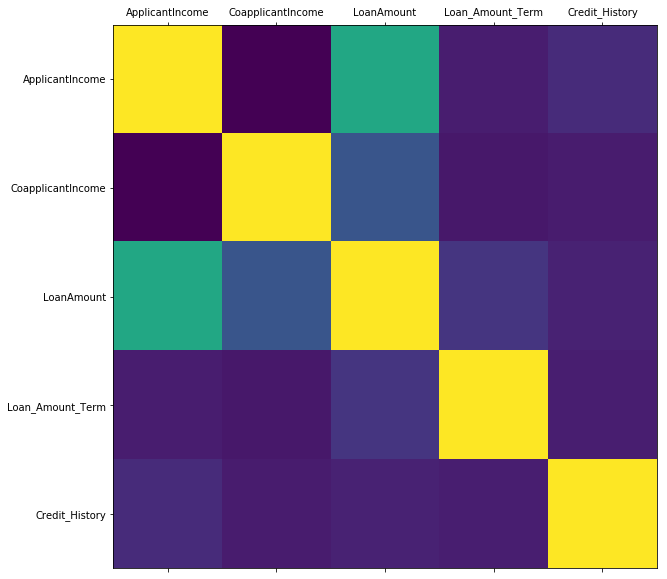

In [7]:
def plot_corr(data, size=10):
    """
    Function plots a graphical correlation matrix for each pair of columns in the dataframe
    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot
    Displays:
        matrix of correlation between columns.  Blue-cyan-yellow-red-darkred => less to more correlated
                                                0 ------------------>  1
                                               Expect a darkred line running from top left to bottom right
    """
    corr = data.corr()    # data frame correlation function
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)   # color code the rectangles by correlation value
    plt.xticks(range(len(corr.columns)), corr.columns)  # draw x tick marks
    plt.yticks(range(len(corr.columns)), corr.columns)  # draw y tick marks
plot_corr(data)
data.corr()

## Only Credit History seems to be correlated to Loan Status

## Separating target from data

In [8]:
X = data.drop('Loan_Status', axis=1)

## Checking for empty values and anomalies

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 12 columns):
Loan_ID              981 non-null object
Gender               957 non-null object
Married              978 non-null object
Dependents           956 non-null object
Education            981 non-null object
Self_Employed        926 non-null object
ApplicantIncome      981 non-null int64
CoapplicantIncome    981 non-null float64
LoanAmount           954 non-null float64
Loan_Amount_Term     961 non-null float64
Credit_History       902 non-null float64
Property_Area        981 non-null object
dtypes: float64(4), int64(1), object(7)
memory usage: 92.0+ KB


In [10]:
X.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,981.000000,981.000000,954.000000,961.000000,902.000000
mean,5179.795107,1601.916330,142.511530,342.201873,0.835920
std,5695.104533,2718.772806,77.421743,65.100602,0.370553
min,0.000000,0.000000,9.000000,6.000000,0.000000
25%,2875.000000,0.000000,100.000000,360.000000,1.000000
50%,3800.000000,1110.000000,126.000000,360.000000,1.000000
75%,5516.000000,2365.000000,162.000000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


### Some data is missing and in some cases Applicant income is 0....so we need to check if this is a possibility

In [11]:
X[X['ApplicantIncome']==0]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
639,LP001153,Male,No,0,Graduate,No,0,24000.0,148.0,360.0,0.0,Rural
730,LP001607,Female,No,0,Not Graduate,No,0,1760.0,180.0,360.0,1.0,Semiurban


### Coapplicant income in these cases isn't 0 so we assume this is fine...

## Futher explorations to inspect if Gender plays a role in mean and median income

In [12]:
X.groupby('Gender').ApplicantIncome.median()

Gender
Female    3634.5
Male      3865.0
Name: ApplicantIncome, dtype: float64

In [13]:
X.groupby('Gender').ApplicantIncome.mean()

Gender
Female    4458.906593
Male      5256.925161
Name: ApplicantIncome, dtype: float64

## Imputing missing values in Self Employed

## Exploring if we can determine Self Employed status through applicant income stats..

In [14]:
X.groupby('Self_Employed').ApplicantIncome.mean()

Self_Employed
No     4892.030979
Yes    6912.579832
Name: ApplicantIncome, dtype: float64

In [15]:
X.groupby('Self_Employed').ApplicantIncome.median()

Self_Employed
No     3708
Yes    5503
Name: ApplicantIncome, dtype: int64

### Income doesn't helps in imputing missing values in Self Employed.

### Checking for majority in Self Employed staus

In [16]:
pd.value_counts(X['Self_Employed'].values, sort=False)

No     807
Yes    119
dtype: int64

## Checking if Education plays a role in Self Employed...

In [17]:
print('Percentage of Non Self Employed Graduates :')
print((sum(X[X['Education']=='Graduate'].Self_Employed == 'No'))/sum((X[X['Education']=='Graduate'].Self_Employed.isnull()==False))*100)

Percentage of Non Self Employed Graduates :
86.94444444444444


In [18]:
print('Percentage of Non Self Employed Non Graduates :')
print((sum(X[X['Education']!='Graduate'].Self_Employed == 'No'))/sum((X[X['Education']!='Graduate'].Self_Employed.isnull()==False))*100)

Percentage of Non Self Employed Non Graduates :
87.86407766990291


### No relation found...simply imputing majority to missing values

In [19]:
X.Self_Employed.fillna('No',inplace=True)

In [20]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 12 columns):
Loan_ID              981 non-null object
Gender               957 non-null object
Married              978 non-null object
Dependents           956 non-null object
Education            981 non-null object
Self_Employed        981 non-null object
ApplicantIncome      981 non-null int64
CoapplicantIncome    981 non-null float64
LoanAmount           954 non-null float64
Loan_Amount_Term     961 non-null float64
Credit_History       902 non-null float64
Property_Area        981 non-null object
dtypes: float64(4), int64(1), object(7)
memory usage: 92.0+ KB


## Imputing missing values in Gender

### Checking for any relation in mean median income and Gender

In [21]:
X.groupby('Gender').CoapplicantIncome.median()

Gender
Female       0.0
Male      1411.0
Name: CoapplicantIncome, dtype: float64

In [22]:
X.groupby('Gender').CoapplicantIncome.mean()

Gender
Female    1132.604396
Male      1716.340542
Name: CoapplicantIncome, dtype: float64

### No relation found...Checking for majority

In [23]:
pd.value_counts(X['Gender'].values, sort=False)

Female    182
Male      775
dtype: int64

### Is Coapplicant income 0 a determinant of Gender ?

In [24]:
print('Percentage of Female with 0 CoapplicantIncome:')
print((sum(X[X['CoapplicantIncome']==0].Gender == 'Female'))/sum((X[X['CoapplicantIncome']==0].Gender.isnull()==False))*100)

Percentage of Female with 0 CoapplicantIncome:
28.400954653937948


In [25]:
print('Percentage of Male with 0 CoapplicantIncome:')
print((sum(X[X['CoapplicantIncome']==0].Gender == 'Male'))/sum((X[X['CoapplicantIncome']==0].Gender.isnull()==False))*100)

Percentage of Male with 0 CoapplicantIncome:
71.59904534606206


### No other relations found...imputing by majority

In [26]:
X.Gender.fillna('Male',inplace=True)

In [27]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 12 columns):
Loan_ID              981 non-null object
Gender               981 non-null object
Married              978 non-null object
Dependents           956 non-null object
Education            981 non-null object
Self_Employed        981 non-null object
ApplicantIncome      981 non-null int64
CoapplicantIncome    981 non-null float64
LoanAmount           954 non-null float64
Loan_Amount_Term     961 non-null float64
Credit_History       902 non-null float64
Property_Area        981 non-null object
dtypes: float64(4), int64(1), object(7)
memory usage: 92.0+ KB


## Imputing Married status

In [28]:
pd.value_counts(X['Married'].values, sort=False)

No     347
Yes    631
dtype: int64

In [29]:
X[X.Married.isnull()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
104,LP001357,Male,NaN,NaN,Graduate,No,3816,754.0,160.0,360.0,1.0,Urban
228,LP001760,Male,NaN,NaN,Graduate,No,4758,0.0,158.0,480.0,1.0,Semiurban
435,LP002393,Female,NaN,NaN,Graduate,No,10047,0.0,NaN,240.0,1.0,Semiurban


## Is Number of Dependants a measure of Married Status

### imputing missing dependants with majority

In [30]:
X.Dependents.fillna(0,inplace=True)

In [31]:
pd.value_counts(X['Dependents'].values, sort=False)

0      25
3+     91
2     160
0     545
1     160
dtype: int64

In [32]:
pd.value_counts(X['Property_Area'].values, sort=False)

Rural        290
Semiurban    349
Urban        342
dtype: int64

### Imputing married status by majority

In [33]:
X.Married.fillna('Yes',inplace=True)

### Imputing Credit_History by majority

In [34]:
X.Credit_History.fillna(1,inplace=True)

In [35]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 12 columns):
Loan_ID              981 non-null object
Gender               981 non-null object
Married              981 non-null object
Dependents           981 non-null object
Education            981 non-null object
Self_Employed        981 non-null object
ApplicantIncome      981 non-null int64
CoapplicantIncome    981 non-null float64
LoanAmount           954 non-null float64
Loan_Amount_Term     961 non-null float64
Credit_History       981 non-null float64
Property_Area        981 non-null object
dtypes: float64(4), int64(1), object(7)
memory usage: 92.0+ KB


## Replacing Label parameters with numerics

In [36]:
cleanup_nums = {"Gender":     {"Male": 1, "Female": 0},
                "Married": {"Yes": 1, "No": 0},
                "Dependents": {'0': 0, '1': 1, '2' : 2, '3+' : 3},
                "Education": {"Graduate": 1, "Not Graduate": 0},
                "Self_Employed": {"Yes": 1, "No": 0},
                "Loan_Status": {'Y':1,'N':0},
                "Property_Area": {'Rural':1,'Semiurban':2,'Urban':3}
               }
cleanup = {"Loan_Status": {'Y':1,'N':0}}
X.replace(cleanup_nums, inplace=True)
data.replace(cleanup, inplace=True)
y = data.Loan_Status

In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 12 columns):
Loan_ID              981 non-null object
Gender               981 non-null int64
Married              981 non-null int64
Dependents           981 non-null int64
Education            981 non-null int64
Self_Employed        981 non-null int64
ApplicantIncome      981 non-null int64
CoapplicantIncome    981 non-null float64
LoanAmount           954 non-null float64
Loan_Amount_Term     961 non-null float64
Credit_History       981 non-null float64
Property_Area        981 non-null int64
dtypes: float64(4), int64(7), object(1)
memory usage: 92.0+ KB


## Loan ID has no relation to Loan Status...dropping the same

In [38]:
X.drop(['Loan_ID'], axis=1, inplace=True)

## Carrying out mean imputation for continuous variables

In [39]:
imp = preprocessing.Imputer()
X = imp.fit_transform(X)

In [40]:
X = pd.DataFrame(X)

In [41]:
X.columns = ['Gender','Married','Dependents','Education','Self_Employed','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History','Property_Area']
X.head(20)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,1.0,0.0,0.0,1.0,0.0,5849.0,0.0,142.51153,360.000000,1.0,3.0
1,1.0,1.0,1.0,1.0,0.0,4583.0,1508.0,128.00000,360.000000,1.0,1.0
2,1.0,1.0,0.0,1.0,1.0,3000.0,0.0,66.00000,360.000000,1.0,3.0
3,1.0,1.0,0.0,0.0,0.0,2583.0,2358.0,120.00000,360.000000,1.0,3.0
4,1.0,0.0,0.0,1.0,0.0,6000.0,0.0,141.00000,360.000000,1.0,3.0
5,1.0,1.0,2.0,1.0,1.0,5417.0,4196.0,267.00000,360.000000,1.0,3.0
6,1.0,1.0,0.0,0.0,0.0,2333.0,1516.0,95.00000,360.000000,1.0,3.0
7,1.0,1.0,3.0,1.0,0.0,3036.0,2504.0,158.00000,360.000000,0.0,2.0
8,1.0,1.0,2.0,1.0,0.0,4006.0,1526.0,168.00000,360.000000,1.0,3.0
9,1.0,1.0,1.0,1.0,0.0,12841.0,10968.0,349.00000,360.000000,1.0,2.0


In [42]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 11 columns):
Gender               981 non-null float64
Married              981 non-null float64
Dependents           981 non-null float64
Education            981 non-null float64
Self_Employed        981 non-null float64
ApplicantIncome      981 non-null float64
CoapplicantIncome    981 non-null float64
LoanAmount           981 non-null float64
Loan_Amount_Term     981 non-null float64
Credit_History       981 non-null float64
Property_Area        981 non-null float64
dtypes: float64(11)
memory usage: 84.4 KB


## Train test split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=123, 
                                                    stratify=y)

## Naive Bayes

In [44]:
from sklearn.naive_bayes import GaussianNB

# create Gaussian Naive Bayes model object and train it with the data
nb_model = GaussianNB()

nb_model.fit(X_train, y_train.ravel())

GaussianNB(priors=None)

In [45]:
# predict values using the training data
nb_predict_test = nb_model.predict(X_test)

# import the performance metrics library
from sklearn import metrics

# Accuracy
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, nb_predict_test)))
print()
print("Classification Report")
print(metrics.classification_report(y_test, nb_predict_test))

Accuracy: 0.8528

Classification Report
             precision    recall  f1-score   support

          0       0.87      0.52      0.65        52
          1       0.85      0.97      0.91       145

avg / total       0.86      0.85      0.84       197



## Random Forest Classifier

In [46]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)      # Create random forest object
rf_model.fit(X_train, y_train.ravel()) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [47]:
rf_predict_test = rf_model.predict(X_test)

# training metrics
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, rf_predict_test)))
print("ROC AUC Score : {0:.4f}".format(roc_auc_score(y_test, rf_predict_test)))

Accuracy: 0.8173
ROC AUC Score : 0.7279


In [48]:
print(metrics.confusion_matrix(y_test, rf_predict_test) )
print("")
print("Classification Report")
print(metrics.classification_report(y_test, rf_predict_test))

[[ 28  24]
 [ 12 133]]

Classification Report
             precision    recall  f1-score   support

          0       0.70      0.54      0.61        52
          1       0.85      0.92      0.88       145

avg / total       0.81      0.82      0.81       197



### Using grid search to find best hyper parameters for Random Forest

In [49]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier(random_state=42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train.ravel())
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  4.7min finished


{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

In [50]:
best_model = grid_search.best_estimator_
pred = best_model.predict(X_test)
print('Accuracy of the RF on test set: {:.3f}'.format(best_model.score(X_test, y_test)))
pred=best_model.predict(X_test)
print("Classification Report")
print(metrics.classification_report(y_test, pred))
print(metrics.recall_score(y_test, pred))
print("ROC AUC Score : {0:.4f}".format(roc_auc_score(y_test, pred)))

Accuracy of the RF on test set: 0.853
Classification Report
             precision    recall  f1-score   support

          0       0.93      0.48      0.63        52
          1       0.84      0.99      0.91       145

avg / total       0.86      0.85      0.84       197

0.9862068965517241
ROC AUC Score : 0.7335


### Visualisation of important features

Text(0,0.5,'Feature Importance Score')

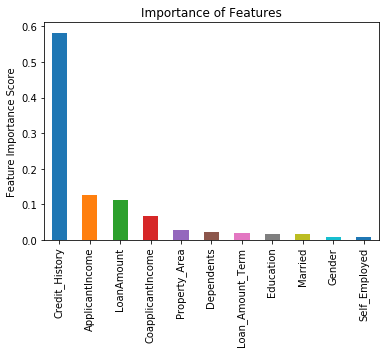

In [51]:
predictors=list(X_train)
feat_imp = pd.Series(best_model.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')

## Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression

lr_model =LogisticRegression(C=0.7, random_state=42)
lr_model.fit(X_train, y_train.ravel())
lr_predict_test = lr_model.predict(X_test)

# training metrics
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, lr_predict_test)))
print(metrics.confusion_matrix(y_test, lr_predict_test) )
print("")
print("Classification Report")
print(metrics.classification_report(y_test, lr_predict_test))
print("ROC AUC Score : {0:.4f}".format(roc_auc_score(y_test, lr_predict_test)))

Accuracy: 0.8528
[[ 25  27]
 [  2 143]]

Classification Report
             precision    recall  f1-score   support

          0       0.93      0.48      0.63        52
          1       0.84      0.99      0.91       145

avg / total       0.86      0.85      0.84       197

ROC AUC Score : 0.7335


### Tuning based on iteration

### Aim is to increase recall score...so that there are less false negative..i.e the deserving get the loan (Applicant Friendly)

1st max value of 0.972 occured at C=0.800


Text(0,0.5,'recall score')

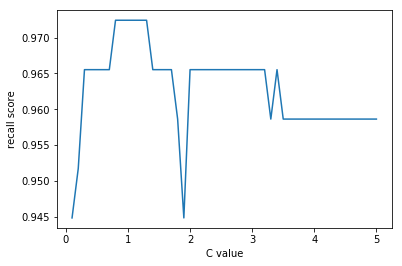

In [53]:
C_start = 0.1
C_end = 5
C_inc = 0.1

C_values, recall_scores = [], []

C_val = C_start
best_recall_score = 0
while (C_val < C_end):
    C_values.append(C_val)
    lr_model_loop = LogisticRegression(C=C_val, class_weight="balanced", random_state=42)
    lr_model_loop.fit(X_train, y_train.ravel())
    lr_predict_loop_test = lr_model_loop.predict(X_test)
    recall_score = metrics.recall_score(y_test, lr_predict_loop_test)
    recall_scores.append(recall_score)
    if (recall_score > best_recall_score):
        best_recall_score = recall_score
        best_lr_predict_test = lr_predict_loop_test
        
    C_val = C_val + C_inc

best_score_C_val = C_values[recall_scores.index(best_recall_score)]
print("1st max value of {0:.3f} occured at C={1:.3f}".format(best_recall_score, best_score_C_val))

%matplotlib inline 
plt.plot(C_values, recall_scores, "-")
plt.xlabel("C value")
plt.ylabel("recall score")

### Testing with best hyper parameters

In [54]:
lr_model =LogisticRegression( class_weight="balanced", C=best_score_C_val, random_state=42)
lr_model.fit(X_train, y_train.ravel())
lr_predict_test = lr_model.predict(X_test)

# training metrics
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, lr_predict_test)))
print(metrics.confusion_matrix(y_test, lr_predict_test) )
print("")
print("Classification Report")
print(metrics.classification_report(y_test, lr_predict_test))
print(metrics.recall_score(y_test, lr_predict_test))
print("ROC AUC Score : {0:.4f}".format(roc_auc_score(y_test, lr_predict_test)))

Accuracy: 0.8477
[[ 26  26]
 [  4 141]]

Classification Report
             precision    recall  f1-score   support

          0       0.87      0.50      0.63        52
          1       0.84      0.97      0.90       145

avg / total       0.85      0.85      0.83       197

0.9724137931034482
ROC AUC Score : 0.7362


## Logistic Regression CV

In [55]:
from sklearn.linear_model import LogisticRegressionCV

### Tuning for best hyper parameters

### Aim is to increase recall score...so that there are less false negative..i.e the deserving get the loan (Applicant Friendly)

1st max value of 0.952 occured at Cs=2.000


Text(0,0.5,'recall score')

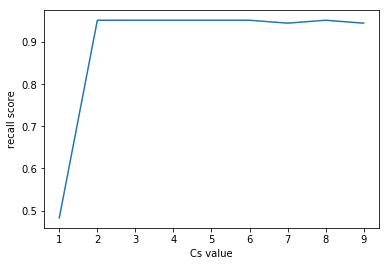

In [56]:
Cs_start = 1
Cs_end = 10
Cs_inc = 1

Cs_values, recall_scores = [], []

Cs_val = Cs_start
best_recall_score = 0
while (Cs_val < Cs_end):
    Cs_values.append(Cs_val)
    lr_model_loop = LogisticRegressionCV(n_jobs=-1, random_state=42, Cs=Cs_val, cv=10, refit=False, class_weight="balanced")
    lr_model_loop.fit(X_train, y_train.ravel())
    lr_predict_loop_test = lr_model_loop.predict(X_test)
    recall_score = metrics.recall_score(y_test, lr_predict_loop_test)
    recall_scores.append(recall_score)
    if (recall_score > best_recall_score):
        best_recall_score = recall_score
        best_lr_predict_test = lr_predict_loop_test
        
    Cs_val = Cs_val + Cs_inc

best_score_Cs_val = Cs_values[recall_scores.index(best_recall_score)]
print("1st max value of {0:.3f} occured at Cs={1:.3f}".format(best_recall_score, best_score_Cs_val))

%matplotlib inline 
plt.plot(Cs_values, recall_scores, "-")
plt.xlabel("Cs value")
plt.ylabel("recall score")

### Testing with best hyper parameters

In [57]:
lr_cv_model = LogisticRegressionCV(n_jobs=-1, random_state=42, Cs=best_score_Cs_val, cv=10, refit=False, class_weight="balanced")  # set number of jobs to -1 which uses all cores to parallelize
lr_cv_model.fit(X_train, y_train.ravel())

LogisticRegressionCV(Cs=2, class_weight='balanced', cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=-1, penalty='l2', random_state=42,
           refit=False, scoring=None, solver='lbfgs', tol=0.0001,
           verbose=0)

In [58]:
lr_cv_predict_test = lr_cv_model.predict(X_test)

# training metrics
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, lr_cv_predict_test)))
print(metrics.confusion_matrix(y_test, lr_cv_predict_test) )
print("")
print("Classification Report")
print(metrics.classification_report(y_test, lr_cv_predict_test))
print(metrics.recall_score(y_test, lr_cv_predict_test))
print("ROC AUC Score : {0:.4f}".format(roc_auc_score(y_test, lr_cv_predict_test)))

Accuracy: 0.8426
[[ 28  24]
 [  7 138]]

Classification Report
             precision    recall  f1-score   support

          0       0.80      0.54      0.64        52
          1       0.85      0.95      0.90       145

avg / total       0.84      0.84      0.83       197

0.9517241379310345
ROC AUC Score : 0.7451


## Gradient Boosting Classifier

Accuracy of the GBM on test set: 0.863
Classification Report
             precision    recall  f1-score   support

          0       0.93      0.52      0.67        52
          1       0.85      0.99      0.91       145

avg / total       0.87      0.86      0.85       197

0.9862068965517241
ROC AUC Score : 0.7527


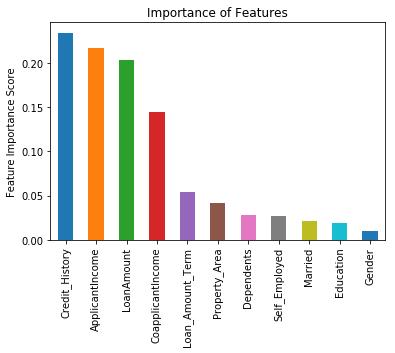

In [59]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV


baseline = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
baseline.fit(X_train,y_train.ravel())
predictors=list(X_train)
feat_imp = pd.Series(baseline.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(baseline.score(X_test, y_test)))
pred=baseline.predict(X_test)
print("Classification Report")
print(metrics.classification_report(y_test, pred))
print(metrics.recall_score(y_test, pred))
print("ROC AUC Score : {0:.4f}".format(roc_auc_score(y_test, pred)))

### Grid Search for best hyper parameters

In [60]:
p_test3 = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 'n_estimators':[100,250,500,750,1000,1250,1500,1750], 'max_depth':[2,3,4,5,6,7]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test3, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(X_train,y_train.ravel())
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

([mean: 0.87251, std: 0.01759, params: {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 100},
  mean: 0.86355, std: 0.01515, params: {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 250},
  mean: 0.84693, std: 0.01669, params: {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 500},
  mean: 0.83931, std: 0.01562, params: {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 750},
  mean: 0.83551, std: 0.01633, params: {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 1000},
  mean: 0.82913, std: 0.01164, params: {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 1250},
  mean: 0.83298, std: 0.01805, params: {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 1500},
  mean: 0.82786, std: 0.01382, params: {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 1750},
  mean: 0.86613, std: 0.01930, params: {'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 100},
  mean: 0.85076, std: 0.01316, params: {'learning_rate': 0.15, 'max_depth': 3, 'n_estim

### Testing with best hyper parameters

Accuracy of the GBM on test set: 0.858
Classification Report
             precision    recall  f1-score   support

          0       0.93      0.50      0.65        52
          1       0.85      0.99      0.91       145

avg / total       0.87      0.86      0.84       197

0.9862068965517241
ROC AUC Score : 0.7431


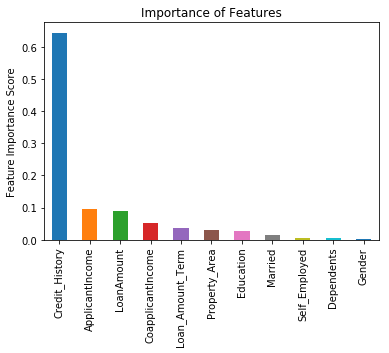

In [61]:
baseline = GradientBoostingClassifier(learning_rate=0.001, n_estimators=1750,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
baseline.fit(X_train,y_train.ravel())
predictors=list(X_train)
feat_imp = pd.Series(baseline.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(baseline.score(X_test, y_test)))
pred=baseline.predict(X_test)
print("Classification Report")
print(metrics.classification_report(y_test, pred))
print(metrics.recall_score(y_test, pred))
print("ROC AUC Score : {0:.4f}".format(roc_auc_score(y_test, pred)))

## SVM model

In [62]:
from sklearn import svm, grid_search
def svc_param_selection(X, y, nfolds,Ker):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel=Ker), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_


### Function above will choose best hyper parameter for a given Kernel

In [63]:
svc_param_selection(X_train,y_train.ravel(),5,'rbf')

{'C': 10, 'gamma': 0.01}

In [64]:
my_svm = svm.SVC(C=10, kernel="rbf",gamma= 0.01)
my_svm.fit(X_train, y_train.ravel())
pred = my_svm.predict(X_test)
# training metrics
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, pred)))
print(metrics.confusion_matrix(y_test, pred) )
print("")
print("Classification Report")
print(metrics.classification_report(y_test, pred))
print(metrics.recall_score(y_test, pred))
print("ROC AUC Score : {0:.4f}".format(roc_auc_score(y_test, pred)))

Accuracy: 0.7411
[[  2  50]
 [  1 144]]

Classification Report
             precision    recall  f1-score   support

          0       0.67      0.04      0.07        52
          1       0.74      0.99      0.85       145

avg / total       0.72      0.74      0.64       197

0.993103448275862
ROC AUC Score : 0.5158


In [65]:
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
pred = clf.predict(X_test)
# training metrics
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, pred)))
print(metrics.confusion_matrix(y_test, pred) )
print("")
print("Classification Report")
print(metrics.classification_report(y_test, pred))
print(metrics.recall_score(y_test, pred))
print("ROC AUC Score : {0:.4f}".format(roc_auc_score(y_test, pred)))

Accuracy: 0.8528
[[ 24  28]
 [  1 144]]

Classification Report
             precision    recall  f1-score   support

          0       0.96      0.46      0.62        52
          1       0.84      0.99      0.91       145

avg / total       0.87      0.85      0.83       197

0.993103448275862
ROC AUC Score : 0.7273
